In [1]:
import sys, subprocess, os
pkgs = "pandas opencv-python pillow scikit-image face-detection cnocr seaborn matplotlib jinja2"
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U"] + pkgs.split())

0

In [2]:
import cv2, numpy as np, requests, os, math, itertools
from pathlib import Path
from PIL import Image, ImageStat
from skimage.feature import local_binary_pattern
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from jinja2 import Template
sns.set(font="Arial Unicode MS")
%config InlineBackend.figure_format='retina'

In [3]:
IMG_DIR   = Path("covers")          # 封面文件夹
CSV_OUT   = "cover_features.csv"
REPORT_HTML = "cover_report.html"
assert IMG_DIR.exists(), f"请将封面文件夹放于 {IMG_DIR.resolve().parent}"

In [4]:
import cv2, numpy as np, requests
from pathlib import Path

WEIGHTS_DIR = Path("weights")
WEIGHTS_DIR.mkdir(exist_ok=True)

prototxt   = WEIGHTS_DIR / "deploy.prototxt"
caffemodel = WEIGHTS_DIR / "res10_300x300_ssd_iter_140000.caffemodel"

PROTOTXT_URL = "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt"
MODEL_URL    = "https://huggingface.co/spaces/Smit1129/NewFaced/resolve/main/res10_300x300_ssd_iter_140000.caffemodel"

def download(url, dst):
    if dst.exists():
        return
    print(f"⬇️  {dst.name}")
    r = requests.get(url, stream=True)
    r.raise_for_status()
    with open(dst, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print(f"✅ {dst.name}")

download(PROTOTXT_URL, prototxt)
download(MODEL_URL, caffemodel)

net = cv2.dnn.readNetFromCaffe(str(prototxt), str(caffemodel))

def face_detect_dnn(im_rgb, conf=0.5):
    h, w = im_rgb.shape[:2]
    blob = cv2.dnn.blobFromImage(im_rgb, 1.0, (300, 300),
                                 mean=[104, 117, 123],
                                 swapRB=False, crop=False)
    net.setInput(blob)
    dets = net.forward()
    boxes = []
    for i in range(dets.shape[2]):
        confidence = dets[0, 0, i, 2]
        if confidence < conf:
            continue
        x1, y1, x2, y2 = dets[0, 0, i, 3:7] * np.array([w, h, w, h])
        boxes.append([int(x1), int(y1), int(x2), int(y2)])
    return boxes

def cv2rgb(path):
    im = cv2.imread(str(path))
    if im is None:
        raise ValueError(f"无法读取 {path}")
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

def face_info(im):
    h, w = im.shape[:2]
    boxes = face_detect_dnn(im)
    n = len(boxes)
    if n == 0:
        return 0, 0., 0.
    x1, y1, x2, y2 = max(boxes, key=lambda b: (b[2]-b[0])*(b[3]-b[1]))
    area_ratio = (x2-x1)*(y2-y1)/(w*h)
    center_offset = abs((x1+x2)/2 - w/2) / (w/2)
    return n, area_ratio, center_offset

In [5]:
def color_moment(im):
    """均值、标准差、偏度、峰度（R/G/B 各 4 维 → 12 维）"""
    arr = np.asarray(im, dtype=np.float32) / 255.0
    mean = arr.mean(axis=(0, 1))
    std  = arr.std(axis=(0, 1))
    skew = ((arr - mean) ** 3).mean(axis=(0, 1)) / (std ** 3 + 1e-8)
    kurt = ((arr - mean) ** 4).mean(axis=(0, 1)) / (std ** 4 + 1e-8) - 3
    return np.hstack([mean, std, skew, kurt])

def dom_color(im, k=3):
    data = im.reshape(-1, 3).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    counts = np.bincount(labels.flatten())
    ratio  = counts / counts.sum()
    order  = np.argsort(ratio)[::-1]
    return centers[order], ratio[order]

def lbp_contrast(im):
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, 8, 1, method='uniform')
    return np.std(lbp)

def thirds_score(im):
    h, w = im.shape[:2]
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    # 计算亮度重心
    M = cv2.moments(gray)
    if M["m00"] == 0:
        return 0.
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    # 四个三分交点
    pts = [(w//3, h//3), (w//3, 2*h//3), (2*w//3, h//3), (2*w//3, 2*h//3)]
    dist = min(np.hypot(cx-x, cy-y) for x, y in pts)
    return max(0., 1 - dist / np.hypot(w, h))

def extract(path):
    im = cv2rgb(path)
    aid = path.stem
    feat = {"aid": aid}

    # 颜色
    col = color_moment(im)
    feat.update({f"color_{i}": col[i] for i in range(12)})
    centers, ratio = dom_color(im)
    feat["dom_r"], feat["dom_g"], feat["dom_b"] = centers[0]
    feat["dom_ratio"] = ratio[0]

    # 人脸
    n, area, offset = face_info(im)
    feat["face_num"], feat["face_area"], feat["face_offset"] = n, area, offset

    # 构图
    feat["lbp_contrast"] = lbp_contrast(im)
    feat["thirds_score"] = thirds_score(im)

    return feat

In [6]:
from tqdm.notebook import tqdm

imgs = list(IMG_DIR.glob("*"))
records = []
for p in tqdm(imgs):
    try:
        records.append(extract(p))
    except Exception as e:
        print("✗", p, e)

df = pd.DataFrame(records)
df.to_csv(CSV_OUT, index=False)
print("✅ 特征已保存 ->", CSV_OUT)
df.head()

  0%|          | 0/100 [00:00<?, ?it/s]

✅ 特征已保存 -> cover_features.csv


,aid,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,...,color_11,dom_r,dom_g,dom_b,dom_ratio,face_num,face_area,face_offset,lbp_contrast,thirds_score
0,115664912129435,0.753264,0.486368,0.197382,0.318621,0.236233,0.236117,-0.931102,0.073812,1.395425,...,0.999735,237.071579,117.069420,18.120134,0.476193,0,0.000000,0.000000,2.059440,0.851316
1,115637414269764,0.634747,0.536221,0.489985,0.340620,0.332425,0.333877,-0.527230,0.267713,0.494701,...,-1.388611,193.576874,121.250626,99.748428,0.362677,0,0.000000,0.000000,1.532247,0.848503
2,115644326478245,0.426580,0.405010,0.366534,0.241091,0.245099,0.259370,0.516918,0.665047,0.879805,...,-0.118419,60.213451,53.275394,45.697041,0.503232,0,0.000000,0.000000,2.163929,0.852084
3,115647732319521,0.797051,0.557272,0.250217,0.181673,0.242118,0.268489,-1.007142,-0.190892,1.446468,...,1.426479,224.497650,163.890686,59.057690,0.542262,0,0.000000,0.000000,1.921447,0.835499
4,115613724837248,0.614938,0.504462,0.418918,0.261097,0.241521,0.218436,-0.641924,-0.072903,0.284107,...,-0.424644,161.808365,119.415482,98.586830,0.519246,1,0.113678,0.134935,2.148196,0.844964


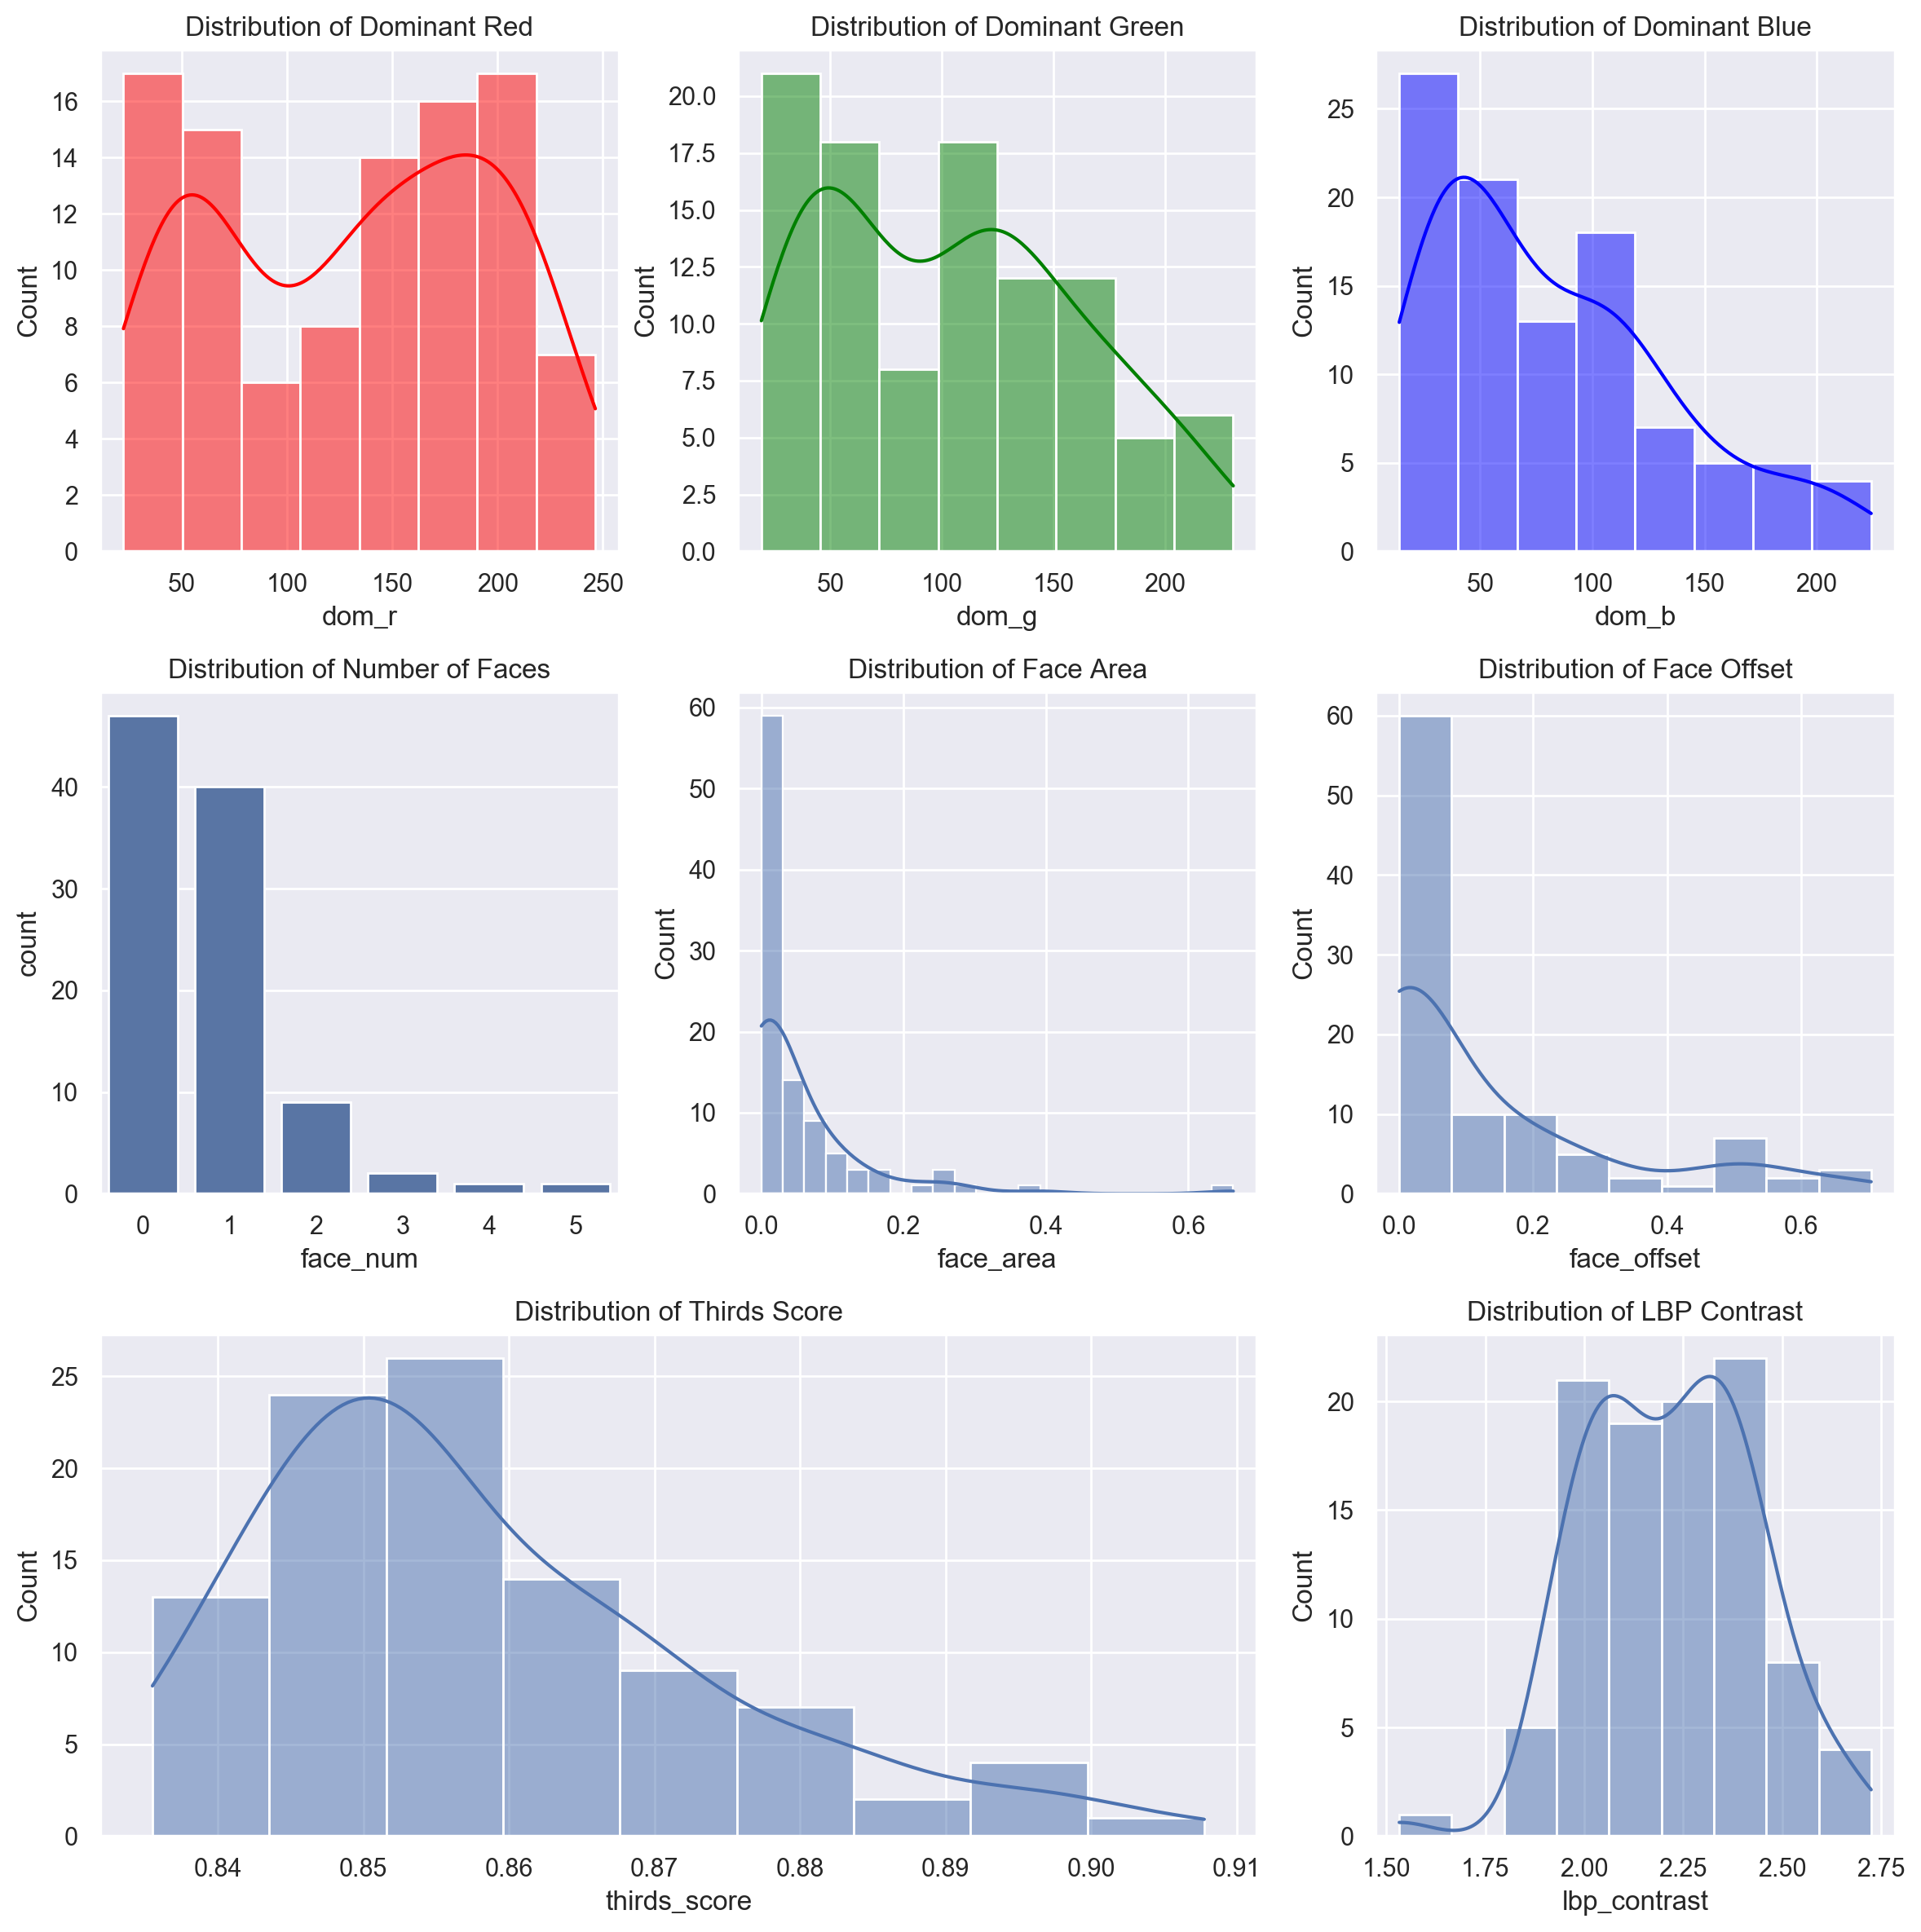

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# 加载数据
df = pd.read_csv('cover_features.csv')

# 创建一个大figure，使用GridSpec布局（3行：第一行RGB，第二行人脸，第三行构图）
fig = plt.figure(figsize=(12, 12))
gs = GridSpec(3, 3, figure=fig) 

# 角度1: 主导颜色分布
ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(df['dom_r'], kde=True, color='red', ax=ax1)
ax1.set_title('Distribution of Dominant Red')

ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(df['dom_g'], kde=True, color='green', ax=ax2)
ax2.set_title('Distribution of Dominant Green')

ax3 = fig.add_subplot(gs[0, 2])
sns.histplot(df['dom_b'], kde=True, color='blue', ax=ax3)
ax3.set_title('Distribution of Dominant Blue')

# 角度2: 人脸特征
ax4 = fig.add_subplot(gs[1, 0])
sns.countplot(x='face_num', data=df, ax=ax4)
ax4.set_title('Distribution of Number of Faces')

ax5 = fig.add_subplot(gs[1, 1])
sns.histplot(df['face_area'], kde=True, ax=ax5)
ax5.set_title('Distribution of Face Area')

ax6 = fig.add_subplot(gs[1, 2])
sns.histplot(df['face_offset'], kde=True, ax=ax6)
ax6.set_title('Distribution of Face Offset')

# 角度3: 构图与对比度
ax7 = fig.add_subplot(gs[2, 0:2])  # 跨2列
sns.histplot(df['thirds_score'], kde=True, ax=ax7)
ax7.set_title('Distribution of Thirds Score')

ax8 = fig.add_subplot(gs[2, 2])  # 只用第三列
sns.histplot(df['lbp_contrast'], kde=True, ax=ax8)
ax8.set_title('Distribution of LBP Contrast')

plt.tight_layout()
plt.show()